# Predict Survival rate in the Titanic Data Set

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore") 

import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, auc


In [2]:
from IPython.display import Image
Image(url='https://kwmp.ca/wp-content/uploads/2018/04/titanic-the-musical.jpg')

In [3]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
# Call pandas' dataframe method on the object 'pd' to read the *.csv datafile at the url into the titanic dataframe
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
# Show the top 10 rows of the titantic dataframe object
titanic.head(10).style.set_properties(**{'background-color': 'black',
                           'color': 'orange',
                           'border-color': 'white'}) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S
5,6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.458300,nan,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.862500,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.075000,nan,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.133300,nan,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.070800,nan,C


In [4]:
print("Shape of the titanic Dataset is: ", titanic.shape)
print("Size of the titanic Dataset is: ", titanic.size)
print("Null Error Rate: ", format(titanic['Survived'].mean()*100,'.2f'),'%')##

Shape of the titanic Dataset is:  (891, 12)
Size of the titanic Dataset is:  10692
Null Error Rate:  38.38 %


### The overall survival rate is very low i.e. 38.38%

In [5]:
# Check the Total count and percentage of the missing values in the dataframe
total = titanic.isnull().sum().sort_values(ascending=False)
percent1 = titanic.isnull().sum()/titanic.isnull().count()*100
percent2 = round(percent1,1).sort_values(ascending=False)
missing_data= pd.concat([total,percent2],axis=1,keys=['Total','Percentage'])
missing_data.head(10).style.set_properties(**{'background-color':'black','color':'orange'})

,Total,Percentage
Cabin,687,77.100000
Age,177,19.900000
Embarked,2,0.200000
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


### Observations- 
- There are 77% missing values in the 'cabin' column, so let's drop this colum as of now.
- Age has 19.9% missing values, so we will deal with it
- Embarked has only 2 missing values, we can impute it easily


In [6]:
# Drop the Cabin Column 
titanic = titanic.drop(['Cabin'],axis=1)

In [7]:
titanic['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [8]:
top = 'S' # Most frequent value in the Embarked column
titanic['Embarked'] = titanic['Embarked'].fillna(top) 

In [9]:
categories = {'S':1, 'C':2, 'Q':3}
titanic['Embarked'] =titanic['Embarked'].map(categories)

In [10]:
titanic.describe().style.set_properties(**{'background-color':'black','color':'orange'})

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.361392
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.635673
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,3.000000


###  What was the Survival rate according to the Pclass?

In [11]:
print("Total Count of Passengers :")
print(titanic['Pclass'].value_counts())
print("*"*50)

print("Survival Count as per the passenger class is :")
Survival_count = titanic[['Pclass','Survived']].groupby(['Pclass'],as_index = False).mean().sort_values(by='Survived',ascending = False)
Survival_count.style.set_properties(**{'background-color':'black','color':'orange'})

Total Count of Passengers :
3    491
1    216
2    184
Name: Pclass, dtype: int64
**************************************************
Survival Count as per the passenger class is :


,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### Class 1 Passengers survival rate is more compared to class 1 & 2

In [12]:
titanic_1 = titanic.groupby(['Pclass','Sex']).mean()
titanic_1.style.set_properties(**{'background-color':'black','color':'orange'})

## What's the survival rate of the passengers based on SibSp 

<AxesSubplot:xlabel='Sex', ylabel='count'>

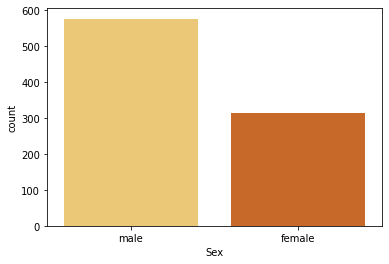

In [13]:
sns.countplot(x='Sex',data=titanic,palette="YlOrBr") 

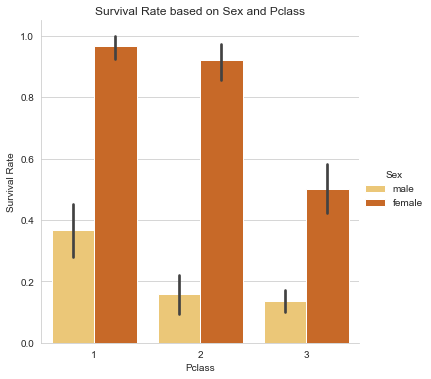

In [14]:
sns.set_style('whitegrid') 
sns.catplot(x='Pclass',y='Survived',hue='Sex',kind='bar',data=titanic,palette="YlOrBr")
plt.ylabel("Survival Rate")
plt.title("Survival Rate based on Sex and Pclass")
plt.show()

In [15]:
# We will drop the Passenger ID column, as it will not contribute in the survival predication
titanic = titanic.drop(['PassengerId'],axis=1)

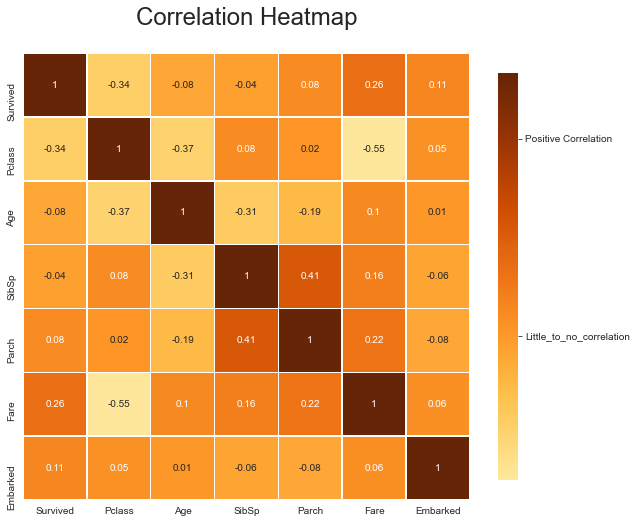

In [16]:
mask = np.triu(np.ones_like(titanic.corr()))
f,ax = plt.subplots(figsize=(10,10))
cmap= sns.color_palette("YlOrBr",as_cmap=True)
sns.heatmap(titanic.corr().round(2),annot=True,cmap=cmap,vmax=1.0,center=0,square=True,lw=0.5,cbar_kws={"shrink":0.75})
ax.set_title('Correlation Heatmap', fontsize=24, y=1.05)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.75,0,0.75])
colorbar.set_ticklabels(['Negative_Correlation','Little_to_no_correlation','Positive Correlation'])

 ### As we can see in the above heatmap SibSp and Parch are coreelated with each other, we will combine this feature into one i.e. Family (No. of family members = SibSp + Parch)

In [17]:
titanic['Family'] = titanic['SibSp'] +titanic['Parch']
titanic = titanic.drop(['SibSp','Parch'],axis=1)
titanic.head().style.set_properties(**{'background-color':'black','color':'orange'})

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Family
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,A/5 21171,7.250000,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,PC 17599,71.283300,2,1
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,STON/O2. 3101282,7.925000,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,113803,53.100000,1,1
4,0,3,"Allen, Mr. William Henry",male,35.000000,373450,8.050000,1,0


In [18]:
titanic['Fare']=titanic['Fare'].astype(int)

In [19]:
# Map Gender Values
genders = {"male": 0, "female": 1}
titanic['Sex'] = titanic['Sex'].map(genders)

In [20]:
titanic['Ticket'].describe() 

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

- In 'Ticket' column, we have 681 unique values, so it will be tricky to convert these into useful categories, let's drop this feature as of now.
- We will also drop the Name column 

In [21]:
titanic = titanic.drop(['Name','Ticket'],axis=1)
titanic.head().style.set_properties(**{'background-color':'black','color':'orange'})

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,0,22.000000,7,1,1
1,1,1,1,38.000000,71,2,1
2,1,3,1,26.000000,7,1,0
3,1,1,1,35.000000,53,1,1
4,0,3,0,35.000000,8,1,0


### Now we will deal with the 'Age' column

In [22]:
# As we have seen above we have total 177 null values in the age column.We will fil those with median
titanic['Age'] =titanic['Age'].fillna(titanic['Age'].median())

In [23]:
# Convert Age column from float datatype to int
titanic['Age'] = titanic['Age'].astype(int)

In [24]:
# We will categorize Age colum in different groups.
titanic.loc[titanic['Age'] <= 11, 'Age'] = 0
titanic.loc[(titanic['Age'] > 11) & (titanic['Age'] <= 18), 'Age'] = 1
titanic.loc[(titanic['Age'] > 18) & (titanic['Age'] <= 22), 'Age'] = 2
titanic.loc[(titanic['Age'] > 22) & (titanic['Age'] <= 27), 'Age'] = 3
titanic.loc[(titanic['Age'] > 27) & (titanic['Age'] <= 33), 'Age'] = 4
titanic.loc[(titanic['Age'] > 33) & (titanic['Age'] <= 40), 'Age'] = 5
titanic.loc[(titanic['Age'] > 40) & (titanic['Age'] <= 66), 'Age'] = 6

In [25]:
titanic.head(10).style.set_properties(**{'background-color':'black','color':'orange'})

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,0,2,7,1,1
1,1,1,1,5,71,2,1
2,1,3,1,3,7,1,0
3,1,1,1,5,53,1,1
4,0,3,0,5,8,1,0
5,0,3,0,4,8,3,0
6,0,1,0,6,51,1,0
7,0,3,0,0,21,1,4
8,1,3,1,3,11,1,2
9,1,2,1,1,30,2,1


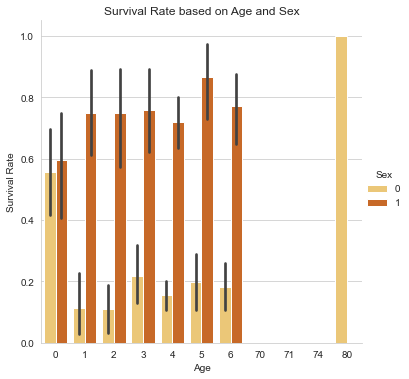

In [26]:
sns.catplot(x='Age',y='Survived',hue='Sex',kind='bar',data=titanic,palette="YlOrBr")
plt.ylabel("Survival Rate")
plt.title("Survival Rate based on Age and Sex")
plt.show()

### Female survival rate in almost all categories are more except the last one.

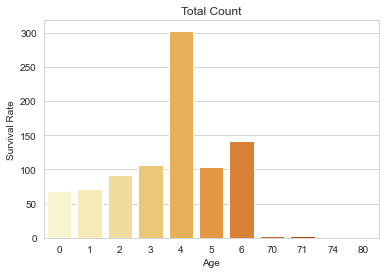

In [27]:
sns.countplot(x="Age", data=titanic,palette="YlOrBr")
plt.ylabel("Survival Rate")
plt.title("Total Count")
plt.show()

#### Survival Rate of the AGe group 4 (27 to 33) is highest i.e. 303, followed by Age Group 6 (40 to 66) i.e. 141 and so on..

### Like 'Age', we will categorize Fare column as well

In [28]:
titanic.loc[titanic['Fare'] <= 8, 'Fare'] = 0
titanic.loc[(titanic['Fare'] > 8) & (titanic['Fare'] <= 14), 'Fare'] = 1
titanic.loc[(titanic['Fare'] > 14) & (titanic['Fare'] <= 31), 'Fare'] = 2
titanic.loc[(titanic['Fare'] > 31) & (titanic['Fare'] <= 99), 'Fare'] = 3
titanic.loc[(titanic['Fare'] > 99) & (titanic['Fare'] <= 250), 'Fare'] = 4
titanic.loc[titanic['Fare'] > 250, 'Fare'] = 5

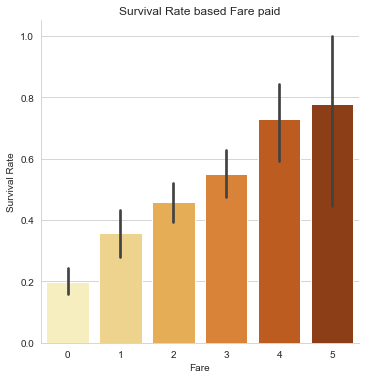

In [29]:
sns.catplot(x='Fare',y='Survived',kind='bar',data=titanic,palette="YlOrBr")
plt.ylabel("Survival Rate")
plt.title("Survival Rate based Fare paid")
plt.show()

- There are total 9 people who baught the highest price ticket and their survival rate is the maximum

Total Value Count of the Fair :
 0    311
2    223
3    158
1    146
4     44
5      9
Name: Fare, dtype: int64


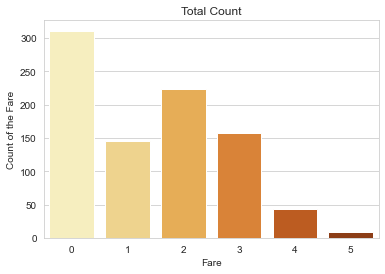

In [30]:
print("Total Value Count of the Fair :\n",titanic['Fare'].value_counts())
sns.countplot(x="Fare", data=titanic,palette="YlOrBr")
plt.ylabel("Count of the Fare")
plt.title("Total Count")
plt.show()

- 311 people baught the fare between $8 to $14 and this is the maximum count 

### Great, now we have dealt with all the required columns
## Model Creation

In [31]:
# We are going to make predictions on Pclass,Sex,Age,SibSp,Parch,Fare
X = titanic[['Pclass','Sex','Age','Fare','Embarked','Family']]
y = titanic['Survived']

In [32]:
# Let's split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [33]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)

DecisionTreeClassifier()

[Text(1416.0095354087453, 786.2785714285714, 'X[1] <= 0.5\ngini = 0.475\nsamples = 596\nvalue = [365, 231]'),
 Text(644.706808460076, 728.0357142857142, 'X[0] <= 1.5\ngini = 0.313\nsamples = 391\nvalue = [315, 76]'),
 Text(198.90684410646386, 669.7928571428571, 'X[2] <= 1.5\ngini = 0.468\nsamples = 83\nvalue = [52, 31]'),
 Text(177.69011406844106, 611.55, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(220.1235741444867, 611.55, 'X[3] <= 2.5\ngini = 0.45\nsamples = 79\nvalue = [52, 27]'),
 Text(53.041825095057035, 553.3071428571428, 'X[3] <= 1.0\ngini = 0.495\nsamples = 31\nvalue = [17, 14]'),
 Text(31.82509505703422, 495.0642857142857, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(74.25855513307985, 495.0642857142857, 'X[2] <= 3.5\ngini = 0.5\nsamples = 28\nvalue = [14, 14]'),
 Text(53.041825095057035, 436.82142857142856, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(95.47528517110266, 436.82142857142856, 'X[2] <= 4.5\ngini = 0.497\nsamples = 26\nvalue = [14, 12]'),
 Text(42

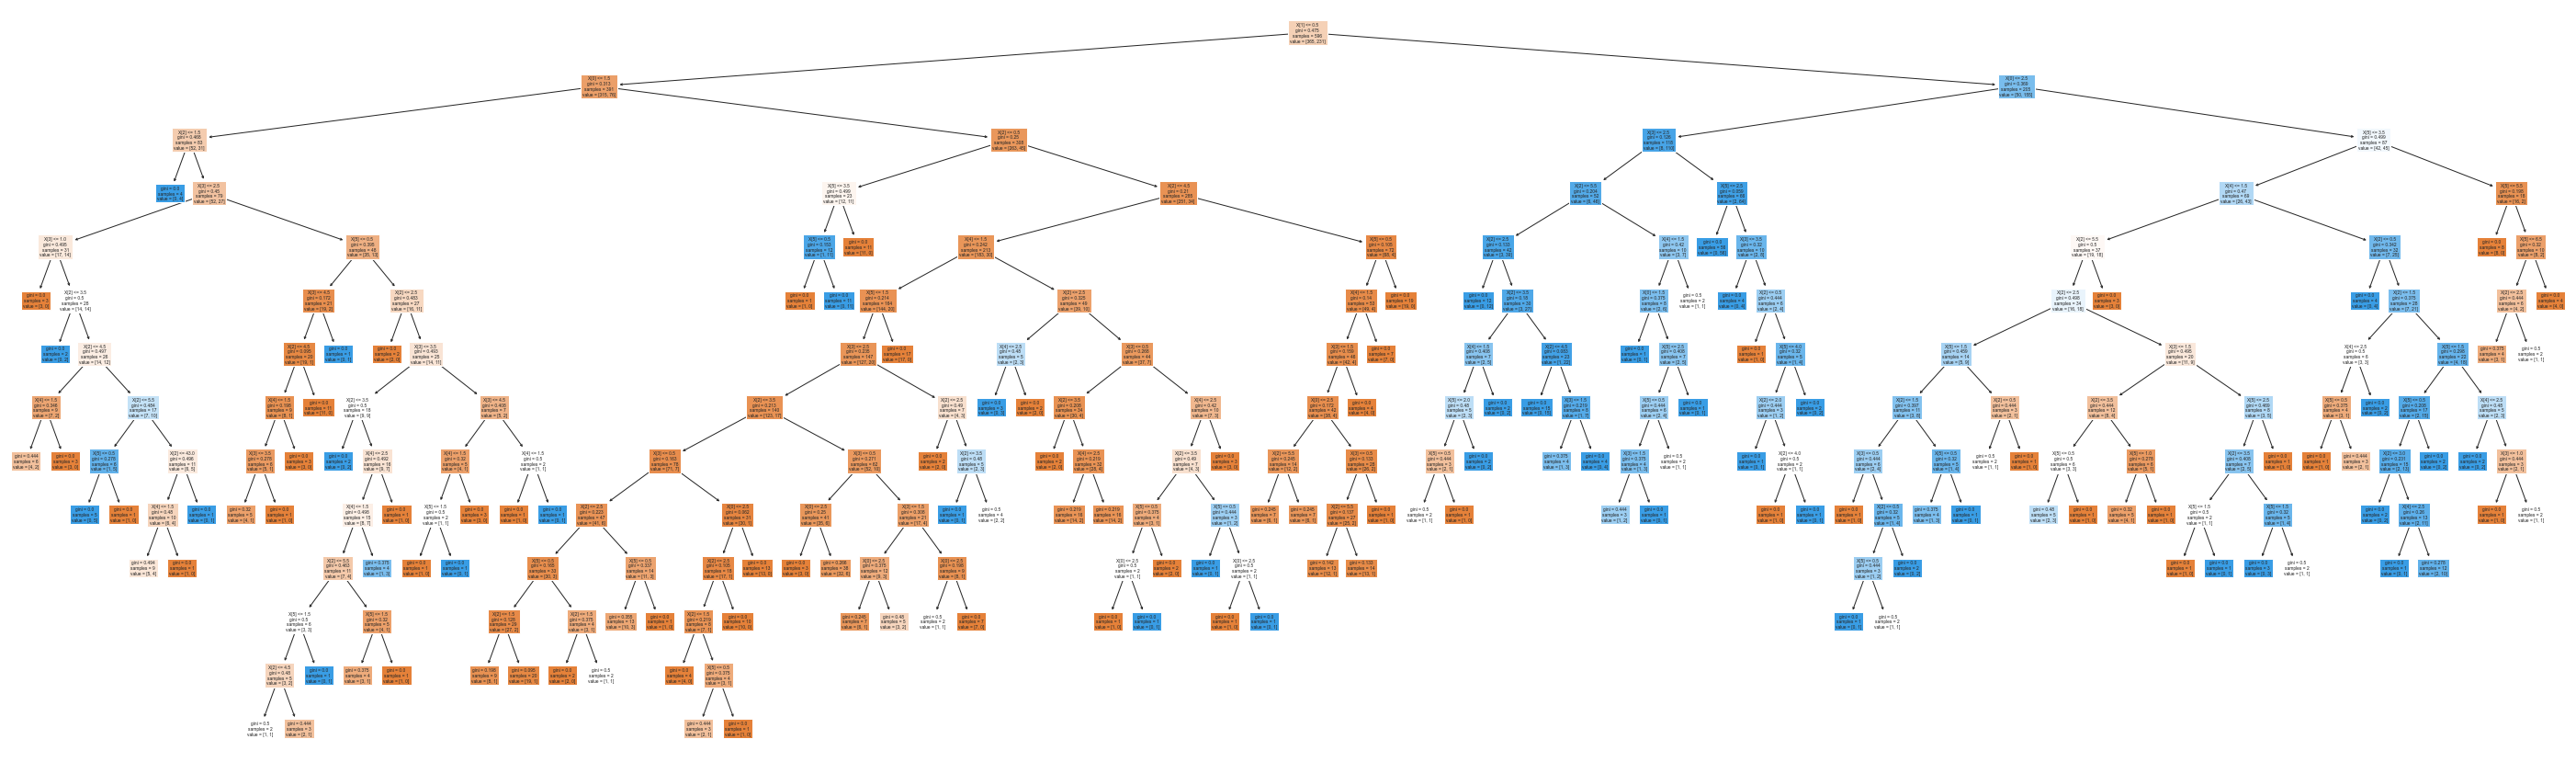

In [34]:
from sklearn import tree
plt.figure(figsize=(50,15))
tree.plot_tree(model,filled=True)

In [35]:
predicted = model.predict(X_test)

In [36]:
print("Model Accuracy of the test data is :", format(metrics.accuracy_score(y_test,predicted)*100,'.2f'),'%')

Model Accuracy of the test data is : 76.27 %


In [37]:
cvs = cross_val_score(model,X,y,cv=5)
print(cvs)

[0.74301676 0.76404494 0.85955056 0.80898876 0.82022472]


In [38]:
## Show cross validation score mean and std
print("Accuracy: %0.4f (+/- %0.4f)" % (cvs.mean(), cvs.std()*2))

Accuracy: 0.7992 (+/- 0.0828)


In [39]:
## Take a look at the confusion matrix ([TN,FN],[FP,TP])
confusion_matrix(y_test,predicted)

array([[157,  27],
       [ 43,  68]], dtype=int64)

In [40]:
## Precision
print("Precision: %0.4f" % precision_score(y_test, predicted))

Precision: 0.7158


In [41]:
## Recall score
print("Recall: %0.4f" % recall_score(y_test, predicted))

Recall: 0.6126


In [42]:
## Print classification report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       184
           1       0.72      0.61      0.66       111

    accuracy                           0.76       295
   macro avg       0.75      0.73      0.74       295
weighted avg       0.76      0.76      0.76       295



In [43]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, predicted)
roc_auc = auc(fp, tp)

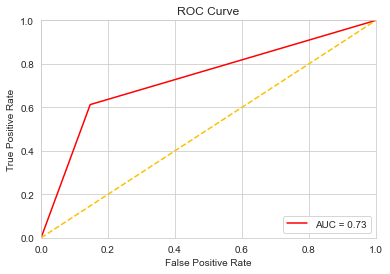

In [44]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',label='AUC = %0.2f'% roc_auc,color='red')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',color='#FAC205')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [45]:

# Let's increase the accuracy of the model by using grid search 
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# 1.Create the parameters list
parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}

# 2.Make an f1_score scoring object.
scorer = make_scorer(f1_score)

# 3.Perform grid search on the classifier using 'scorer' as the scoring method.
grid_obj = GridSearchCV(model, parameters, scoring = scorer)

# 4.Fit the grid search object to the training data and find the optimal parameters.
grid_fit = grid_obj.fit(X_train, y_train)

# 5.Get the estimator.
best_clf = grid_fit.best_estimator_

In [46]:
best_clf

DecisionTreeClassifier(max_depth=8, min_samples_leaf=6, min_samples_split=8)

In [47]:
from sklearn.metrics import accuracy_score
# TODO: Train the model
best_clf.fit(X_train, y_train)

# TODO: Make predictions
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

# TODO: Calculate the accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.8506711409395973
The test accuracy is 0.8135593220338984


In [48]:
# We will check wihich features played the most important role in prediction of survial rate
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

<AxesSubplot:xlabel='feature'>

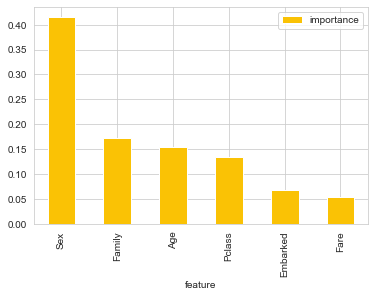

In [49]:
importances.plot.bar(color="#FAC205")

## Let's train our model again with top 5 features - 

In [50]:
X = titanic[['Pclass','Sex','Age','Fare','Family']]
y = titanic['Survived']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
model2 = DecisionTreeClassifier()
model2.fit(X_train,y_train)

DecisionTreeClassifier()

In [52]:
predicted2 = model2.predict(X_test)
#Accuracy = round(model2.score(X_train, y_train) * 100, 2)
print("Model Accuracy of the test data is :", format(metrics.accuracy_score(y_test,predicted2)*100,'.2f'),'%')

Model Accuracy of the test data is : 82.03 %


### So, if we do not include the 'Embarked' column, our accuracy has been increased.

## This can be further tested with other ML algorithms as well 